# Get Started: DCGAN for Fashion-MNIST


This Colab notebook is a DCGAN implementation with TensorFlow 2 / Keras, trained with Fashion-MNIST to generates gray-scale 28x28x1 images. 



## Imports

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

Its always a good practice to check the current version of TensorFlow...

In [3]:
print(tf.version.VERSION)

2.9.2


## Prepare Fashion-MNIST data
The first step is to get data ready for training.


### Loading

In [4]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


There are 60,000 training gray scale images in Fashion-MNIST.

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
type(train_images)

numpy.ndarray

### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

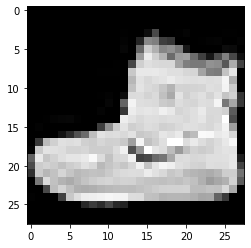

In [7]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

### Preprocessing

In [8]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5  

(60000, 28, 28)
(60000, 28, 28, 1)


## The generator model

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [9]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [10]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [11]:
# build the generator model
generator = build_generator() 

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      51

## The discriminator model

Define the discriminator model architecture with the Keras `Sequential` API

In [13]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [14]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

## Define `DCGAN` class: override `train_step`
Subclass `keras.Model` and override `train_step` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation. 

**The discriminator loss** includes both the loss from the real images and the loss from the fake images.  
**The generator loss** is calculated with thefake images.


In [16]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Use Keras `Callback` to monitor training

The nice thing about overriding `train_step` of `keras.Model` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to visually inspect the progress of the generator. You can also save the generator model at the end of the training which could potentially be used for inference later.

In [17]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Train the DCGAN model

Compile the `dcgan` model, with the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** loss functionas recommended by the paper. In future GAN tutorials, you will learn other loss functions for other GAN variants.

Putting together the `dcgan` model.

In [18]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

Compile the `dcgan` model.

In [19]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Now we simply call `model.fit()` to traing the `dcgan` model!

Epoch 1/50
   4/1875 [..............................] - ETA: 41s - d_loss: 0.7246 - g_loss: 1.0761    

1873/1875 [============================>.] - ETA: 0s - d_loss: 0.2868 - g_loss: 1.6076

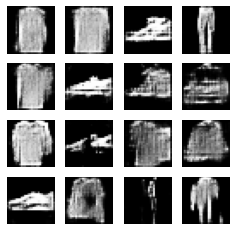

1875/1875 [==============================] - 46s 19ms/step - d_loss: 0.2872 - g_loss: 1.6072
Epoch 2/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.5958 - g_loss: 0.9428

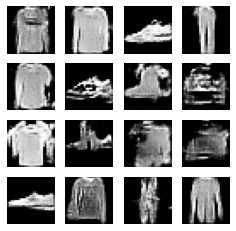

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.5958 - g_loss: 0.9430
Epoch 3/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6519 - g_loss: 0.9249

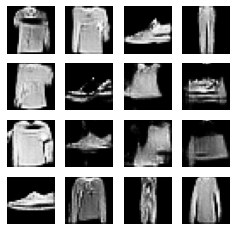

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6519 - g_loss: 0.9248
Epoch 4/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6609 - g_loss: 0.8935

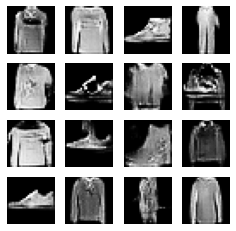

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6608 - g_loss: 0.8935
Epoch 5/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6639 - g_loss: 0.8616

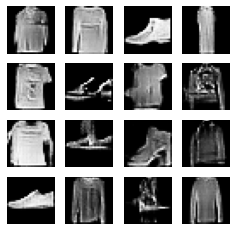

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6640 - g_loss: 0.8615
Epoch 6/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6668 - g_loss: 0.8506

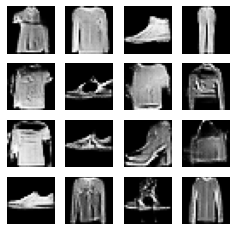

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6668 - g_loss: 0.8507
Epoch 7/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6665 - g_loss: 0.8368

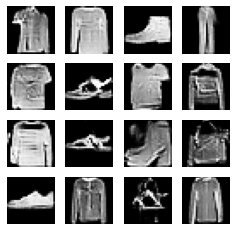

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6666 - g_loss: 0.8368
Epoch 8/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6674 - g_loss: 0.8376

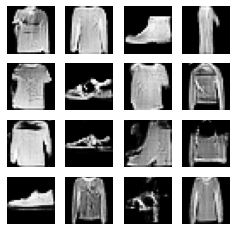

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6674 - g_loss: 0.8376
Epoch 9/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6671 - g_loss: 0.8293

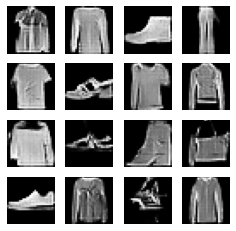

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6671 - g_loss: 0.8293
Epoch 10/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6675 - g_loss: 0.8334

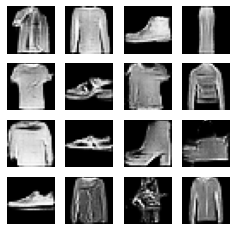

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6675 - g_loss: 0.8335
Epoch 11/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6680 - g_loss: 0.8261

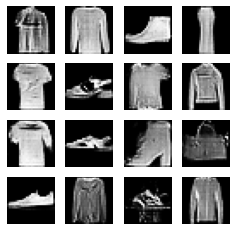

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6681 - g_loss: 0.8263
Epoch 12/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6678 - g_loss: 0.8282

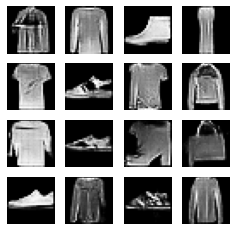

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6678 - g_loss: 0.8282
Epoch 13/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6677 - g_loss: 0.8277

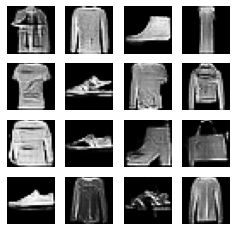

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6676 - g_loss: 0.8277
Epoch 14/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6667 - g_loss: 0.8240

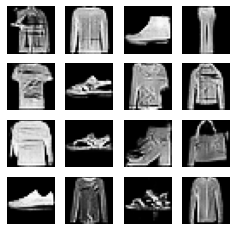

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6667 - g_loss: 0.8240
Epoch 15/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6652 - g_loss: 0.8280

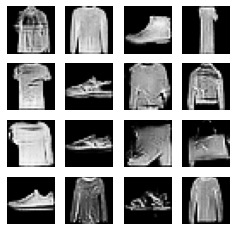

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6652 - g_loss: 0.8280
Epoch 16/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6672 - g_loss: 0.8259

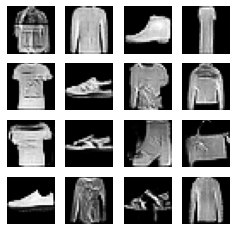

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6672 - g_loss: 0.8259
Epoch 17/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6687 - g_loss: 0.8254

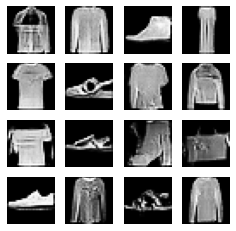

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6687 - g_loss: 0.8254
Epoch 18/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6669 - g_loss: 0.8196

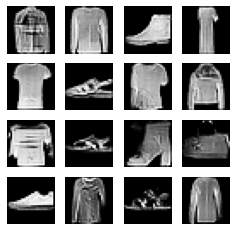

1875/1875 [==============================] - 37s 19ms/step - d_loss: 0.6669 - g_loss: 0.8197
Epoch 19/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6680 - g_loss: 0.8216

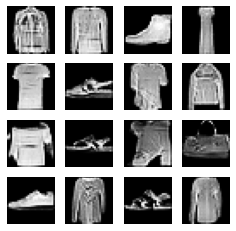

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6680 - g_loss: 0.8217
Epoch 20/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6672 - g_loss: 0.8200

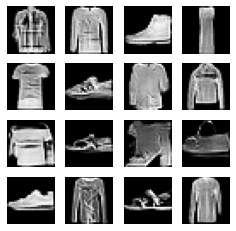

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6672 - g_loss: 0.8199
Epoch 21/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6672 - g_loss: 0.8198

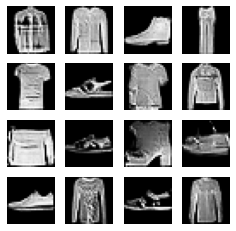

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6672 - g_loss: 0.8198
Epoch 22/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6659 - g_loss: 0.8199

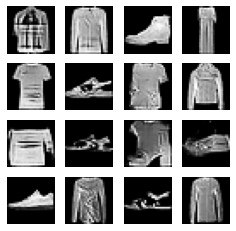

1875/1875 [==============================] - 37s 19ms/step - d_loss: 0.6659 - g_loss: 0.8198
Epoch 23/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6681 - g_loss: 0.8154

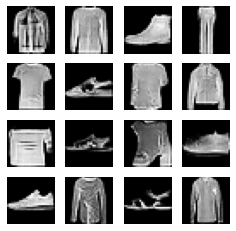

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6681 - g_loss: 0.8154
Epoch 24/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6683 - g_loss: 0.8183

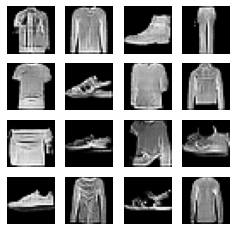

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6683 - g_loss: 0.8184
Epoch 25/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6670 - g_loss: 0.8155

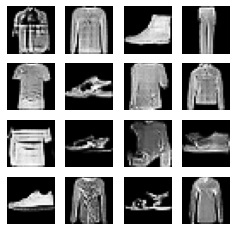

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6670 - g_loss: 0.8155
Epoch 26/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6672 - g_loss: 0.8176

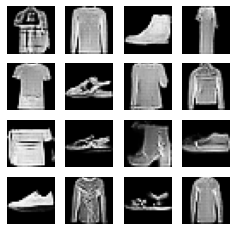

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6672 - g_loss: 0.8175
Epoch 27/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6663 - g_loss: 0.8168

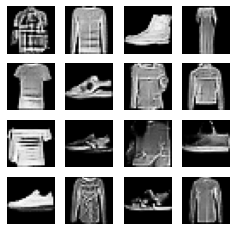

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6662 - g_loss: 0.8168
Epoch 28/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6666 - g_loss: 0.8200

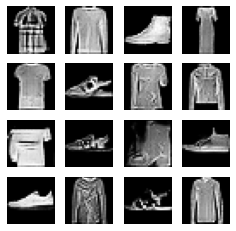

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6666 - g_loss: 0.8199
Epoch 29/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6671 - g_loss: 0.8145

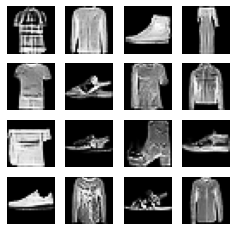

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6671 - g_loss: 0.8146
Epoch 30/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6667 - g_loss: 0.8146

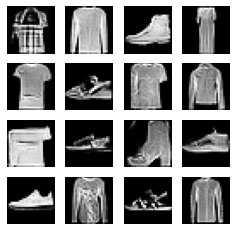

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6667 - g_loss: 0.8147
Epoch 31/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6679 - g_loss: 0.8183

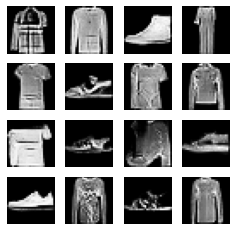

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6679 - g_loss: 0.8182
Epoch 32/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6672 - g_loss: 0.8162

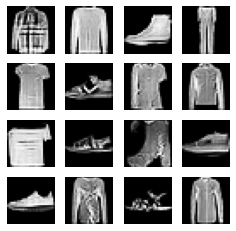

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6671 - g_loss: 0.8163
Epoch 33/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6668 - g_loss: 0.8155

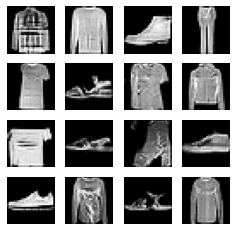

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6668 - g_loss: 0.8154
Epoch 34/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6673 - g_loss: 0.8152

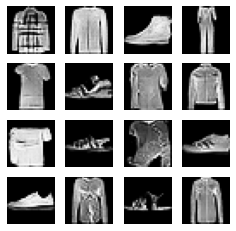

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6673 - g_loss: 0.8152
Epoch 35/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6674 - g_loss: 0.8151

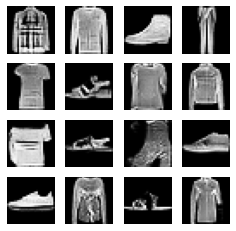

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6674 - g_loss: 0.8151
Epoch 36/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6666 - g_loss: 0.8160

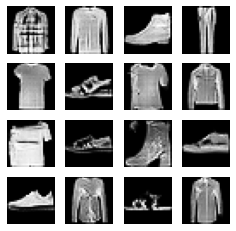

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6666 - g_loss: 0.8160
Epoch 37/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6657 - g_loss: 0.8149

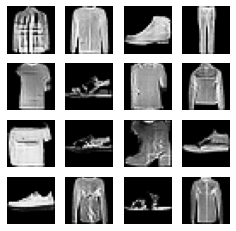

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6656 - g_loss: 0.8149
Epoch 38/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6666 - g_loss: 0.8189

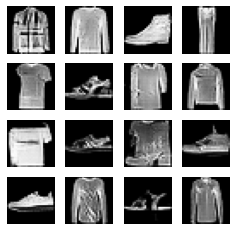

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6666 - g_loss: 0.8189
Epoch 39/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6661 - g_loss: 0.8185

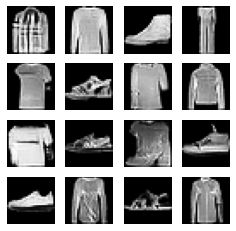

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6662 - g_loss: 0.8185
Epoch 40/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6654 - g_loss: 0.8197

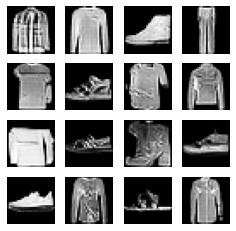

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6654 - g_loss: 0.8197
Epoch 41/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6663 - g_loss: 0.8184

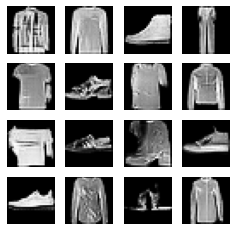

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6663 - g_loss: 0.8184
Epoch 42/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6652 - g_loss: 0.8240

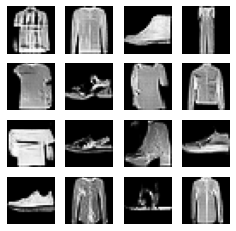

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6652 - g_loss: 0.8240
Epoch 43/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6637 - g_loss: 0.8211

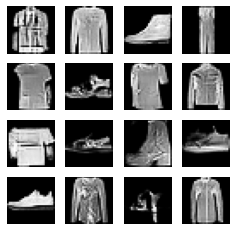

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6637 - g_loss: 0.8211
Epoch 44/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6644 - g_loss: 0.8194

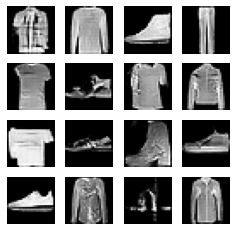

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6643 - g_loss: 0.8194
Epoch 45/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6651 - g_loss: 0.8193

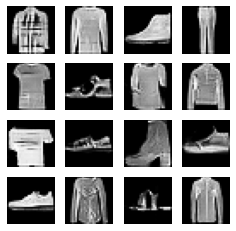

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6651 - g_loss: 0.8193
Epoch 46/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6642 - g_loss: 0.8238

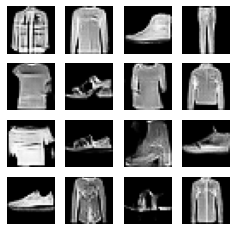

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6642 - g_loss: 0.8238
Epoch 47/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6625 - g_loss: 0.8215

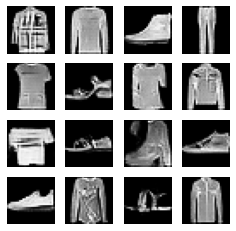

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6625 - g_loss: 0.8215
Epoch 48/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6638 - g_loss: 0.8184

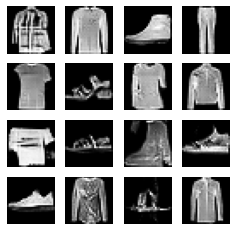

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6638 - g_loss: 0.8184
Epoch 49/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6638 - g_loss: 0.8203

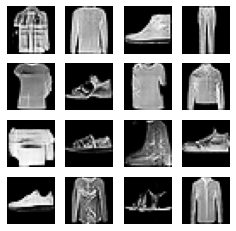

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6637 - g_loss: 0.8202
Epoch 50/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6636 - g_loss: 0.8265

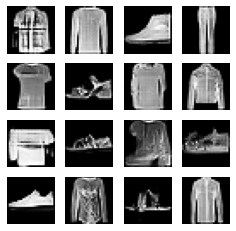

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6636 - g_loss: 0.8265


In [20]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])